# Plots of BlobDetector Algorithm on Dask

In [1]:
%matplotlib inline
import os
import pandas as pd
pd.options.display.width = 180
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
from glob import glob

from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

import numpy as np

import ast
from bokeh.palettes import viridis
from toolz import valmap, merge, memoize
import random
import itertools

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

def merge_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

Wrangle data from watershed dask runs

In [2]:
task_stream_palette = list(viridis(25))
random.shuffle(task_stream_palette)

counter = itertools.count()

_incrementing_index_cache = dict()


@memoize(cache=_incrementing_index_cache)
def incrementing_index(o):
    return next(counter)


def color_of(o, palette=task_stream_palette):
    return palette[incrementing_index(o) % len(palette)]

def color_of_message(key):
        return color_of(key)

colors = {'transfer': 'red',
          'disk-write': 'orange',
          'disk-read': 'orange',
          'deserialize': 'gray',
          'compute': color_of_message}


alphas = {'transfer': 0.4,
          'compute': 1,
          'deserialize': 0.4,
          'disk-write': 0.4,
          'disk-read': 0.4}


prefix = {'transfer': 'transfer-',
          'disk-write': 'disk-write-',
          'disk-read': 'disk-read-',
          'deserialize': 'deserialize-',
          'compute': ''}


def key_split(s):

    if type(s) is bytes:
        s = s.decode()
    if type(s) is tuple:
        s = s[0]
    try:
        words = s.split('-')
        if not words[0][0].isalpha():
            result = words[0].lstrip("'(\"")
        else:
            result = words[0]
        for word in words[1:]:
            if word.isalpha() and not (len(word) == 8 and
                                       hex_pattern.match(word) is not None):
                result += '-' + word
            else:
                break
        if len(result) == 32 and re.match(r'[a-f0-9]{32}', result):
            return 'data'
        else:
            if result[0] == '<':
                result = result.strip('<>').split()[0].split('.')[-1]
            return result
    except:
        return 'Other'



def daskprofiler(filename):

    profFile = open(filename)
    profiles = profFile.readlines()
    buffer = [ast.literal_eval(x) for x in profiles]
    workIds = {}
    id = 1

    L_start = []
    L_stop = []
    L_duration = []
    L_key = []
    L_action = []
    L_name = []
    L_color = []
    L_alpha = []
    L_y = []

    for msg in buffer:
        key = msg[0]
        name = key_split(key)
        startstops = msg[-1]
        if not workIds.has_key(msg[3]):
            workIds[msg[3]]=id
            id+=1

        for action, start, stop in startstops:
            color = colors[action]
            if type(color) is not str:
                color = color(name)

            L_start.append(start)
            L_stop.append(stop)
            L_duration.append((stop - start))
            L_key.append(key)
            L_action.append(action)
            L_name.append(name)
            L_color.append(color)
            L_alpha.append(alphas[action])
            L_y.append(workIds[msg[3]])


    return pd.DataFrame.from_dict({'start': L_start,
                                   'stop': L_stop,
                                   'duration': L_duration,
                                   'key': L_key,
                                   'name': L_name,
                                   'action':L_action,
                                   'color': L_color,
                                   'alpha': L_alpha,
                                   'y': L_y
                                  })

In [5]:
folder = 'data_blobdetector_dask'

data_range = '1[0-9]'
weak_data_configs   = [{'config' : '24tasks_24cores_%s.txt'   % (data_range),   'nodes' : 1},
                       {'config' : '48tasks_48cores_%s.txt'   % (data_range),   'nodes' : 2},
                       {'config' : '96tasks_96cores_%s.txt'   % (data_range),   'nodes' : 4},
                       {'config' : '192tasks_192cores_%s.txt' % (data_range), 'nodes' : 8}
                      ]
strong_data_configs = [{'config' : '192tasks_24cores_%s.txt'  % (data_range),  'nodes' : 1},
                       {'config' : '192tasks_48cores_%s.txt'  % (data_range),  'nodes' : 2},
                       {'config' : '192tasks_96cores_%s.txt'  % (data_range),  'nodes' : 4},
                       {'config' : '192tasks_192cores_%s.txt' , 'nodes' : 8}
                      ]

relevant_features = ['action', 'duration', 'ttc', 'config', 'nodes']

raw_weakdf    = pd.DataFrame(columns=relevant_features)
raw_strongdf  = pd.DataFrame(columns=relevant_features)

for weak_config, strong_config in zip(weak_data_configs, strong_data_configs):

    # gather weak scale data
    for singular_data in glob(os.path.join(folder, '*' + weak_config['config'] + '*')):

        dask_profiles = daskprofiler(singular_data)
        
        compute_profiles = dask_profiles.where(dask_profiles['action'] == 'compute').dropna()
        compute_summary  = {'action'   : 'compute',
                            'duration' : compute_profiles['duration'],
                            'ttc'      : compute_profiles['stop'].max() - compute_profiles['start'].min(),
                            'config'   : weak_config['config'],
                            'nodes'    : weak_config['nodes']
                           }
        
        deserialize_profiles = dask_profiles.where(dask_profiles['action'] == 'deserialize').dropna()
        deserialize_summary  = {'action'   : 'deserialize',
                                'duration' : deserialize_profiles['duration'],
                                'ttc'      : deserialize_profiles['stop'].max() - deserialize_profiles['start'].min(),
                                'config'   : weak_config['config'],
                                'nodes'    : weak_config['nodes']
                                }
        
        raw_weakdf = raw_weakdf.append(compute_summary, ignore_index=True).reset_index(drop=True)
        raw_weakdf = raw_weakdf.append(deserialize_summary, ignore_index=True).reset_index(drop=True)
    
    # gather strong scale data
    for singular_data in glob(os.path.join(folder, '*' + strong_config['config'] + '*')):
        
        dask_profiles = daskprofiler(singular_data)
        
        compute_profiles = dask_profiles.where(dask_profiles['action'] == 'compute').dropna()
        compute_summary  = {'action'   : 'compute',
                            'duration' : compute_profiles['duration'].mean(),
                            'ttc'      : compute_profiles['stop'].max() - compute_profiles['start'].min(),
                            'config'   : weak_config['config'],
                            'nodes'    : weak_config['nodes']
                           }
        
        deserialize_profiles = dask_profiles.where(dask_profiles['action'] == 'deserialize').dropna()
        deserialize_summary  = {'action'   : 'deserialize',
                                'duration' : deserialize_profiles['duration'].mean(),
                                'ttc'      : deserialize_profiles['stop'].max() - deserialize_profiles['start'].min(),
                                'config'   : weak_config['config'],
                                'nodes'    : weak_config['nodes']
                                }
        
        raw_strongdf = raw_strongdf.append(compute_summary, ignore_index=True).reset_index(drop=True)
        raw_strongdf = raw_strongdf.append(deserialize_summary, ignore_index=True).reset_index(drop=True)

        
weak_compute_df = raw_weakdf.where(raw_weakdf['action'] == 'compute').dropna().reset_index(drop=True)

strong_compute_df = raw_strongdf.where(raw_strongdf['action'] == 'compute').dropna().reset_index(drop=True)

try:
    weak_mean    = weak_compute_df[['ttc', 'nodes', 'action']].groupby(['nodes', 'action']).mean().unstack()
    weak_error   = weak_compute_df[['ttc', 'nodes', 'action']].groupby(['nodes', 'action']).std().unstack()
except KeyError:
    pass

try:
    strong_mean  = strong_compute_df[['ttc', 'nodes', 'action']].groupby(['nodes', 'action']).mean().unstack()
    strong_error = strong_compute_df[['ttc', 'nodes', 'action']].groupby(['nodes', 'action']).std().unstack()
except KeyError:
    pass


# Weak and Strong Scaling Plots

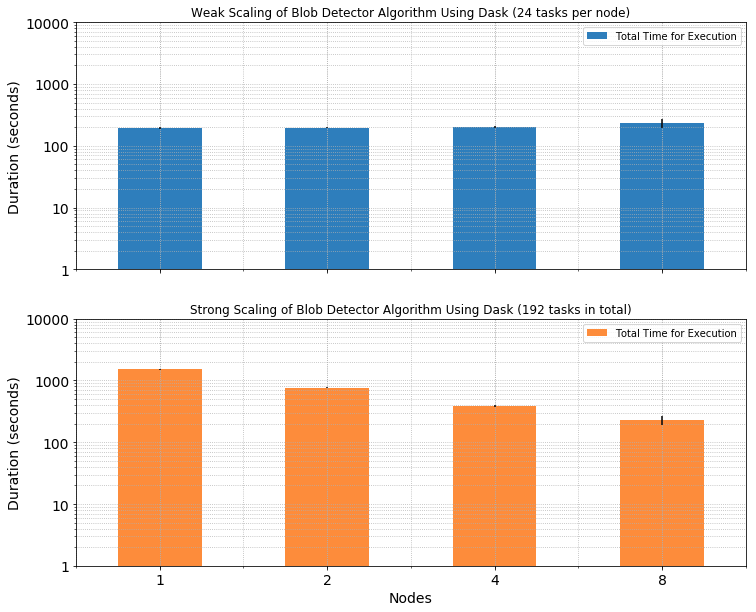

In [6]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
fig.set_size_inches(12,10)

yticks = [1, 10, 100, 1000, 10000]
yticklabels = [str(ytick) for ytick in yticks]

blues   = cm.get_cmap(plt.get_cmap('Blues'))
greens  = cm.get_cmap(plt.get_cmap('Greens'))
reds    = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys   = cm.get_cmap(plt.get_cmap('Greys'))

weak_color = blues(0.7)
strong_color = oranges(0.5)

weak_kwargs    = {
                 'kind'     : 'bar',
                 'log'      : True,
                 'fontsize' : 14,
                 'title'    : 'Weak Scaling of Blob Detector Algorithm Using Dask (24 tasks per node)',
                 'ax'       : axes[0],
                 'yerr'     : weak_error,
                 'color'    : [weak_color]
                  }
strong_kwargs  = {
                 'kind'     : 'bar',
                 'log'      : True,
                 'fontsize' : 14,
                 'title'    : 'Strong Scaling of Blob Detector Algorithm Using Dask (192 tasks in total)',
                 'ax'       : axes[1],
                 'yerr'     : strong_error,
                 'color'    : [strong_color]
                }

weak_scale_plot = weak_mean.plot(**weak_kwargs)
weak_scale_plot.set_ylabel('Duration (seconds)', fontsize=14)
weak_scale_plot.set_ylim(bottom=min(yticks), top=max(yticks))
weak_scale_plot.set_yticks(yticks)
weak_scale_plot.set_yticklabels(yticklabels, fontsize=14)
weak_scale_plot.grid('on', which='both', linestyle=':')
axes[0].legend(['Total Time for Execution'])

strong_scale_plot = strong_mean.plot(**strong_kwargs)
strong_scale_plot.set_ylabel('Duration (seconds)', fontsize=14)
strong_scale_plot.set_ylim(bottom=min(yticks), top=max(yticks))
strong_scale_plot.set_yticks(yticks)
strong_scale_plot.set_yticklabels(yticklabels, fontsize=14)
strong_scale_plot.set_xticklabels(['1','2','4','8'], rotation=0, fontsize=14)
strong_scale_plot.grid('on', which='both', linestyle=':')
strong_scale_plot.set_xlabel('Nodes', fontsize=14)
axes[1].legend(['Total Time for Execution'])


# Speedup Plots

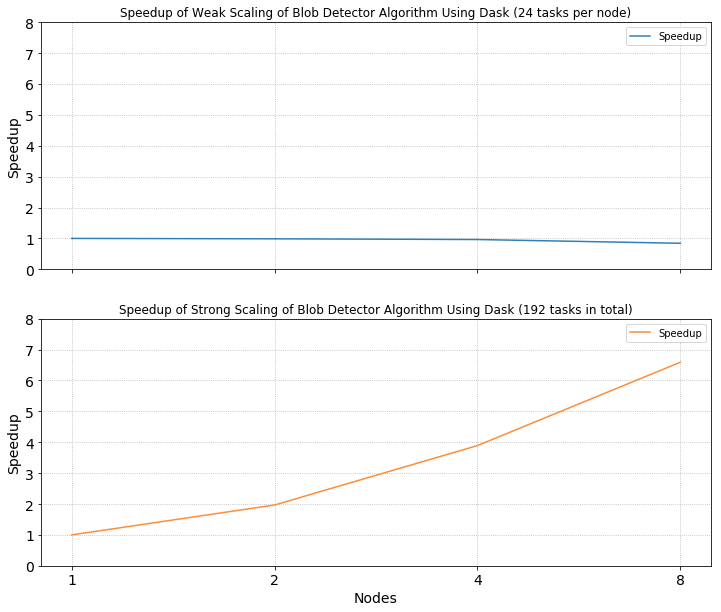

In [143]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
fig.set_size_inches(12,10)

weak_speedups = pd.DataFrame(columns=['nodes', 'speedup'])
for i in range(len(weak_mean['ttc']['compute'])):
    nodes   = weak_mean.index.get_values()[i]
    speedup = weak_mean['ttc']['compute'].iloc[0] / weak_mean['ttc']['compute'].iloc[i]
    data = {'nodes': nodes, 'speedup': speedup}
    weak_speedups = weak_speedups.append(data, ignore_index=True).reset_index(drop=True)
weak_speedups = weak_speedups.set_index('nodes')

strong_speedups = pd.DataFrame(columns=['nodes', 'speedup'])
for i in range(len(strong_mean['ttc']['compute'])):
    nodes   = strong_mean.index.get_values()[i]
    speedup = strong_mean['ttc']['compute'].iloc[0] / strong_mean['ttc']['compute'].iloc[i]
    data = {'nodes': nodes, 'speedup': speedup}
    strong_speedups = strong_speedups.append(data, ignore_index=True).reset_index(drop=True)
strong_speedups = strong_speedups.set_index('nodes')

yticks = list(range(9))
yticklabels = [str(i) for i in range(9)]

weak_color = blues(0.7)
strong_color = oranges(0.5)

weak_kwargs    = {
                 'kind'     : 'line',
                 'fontsize' : 14,
                 'title'    : 'Speedup of Weak Scaling of Blob Detector Algorithm Using Dask (24 tasks per node)',
                 'ax'       : axes[0],
                 'color'    : [blues(0.7)]
                  }
strong_kwargs  = {
                 'kind'     : 'line',
                 'fontsize' : 14,
                 'title'    : 'Speedup of Strong Scaling of Blob Detector Algorithm Using Dask (192 tasks in total)',
                 'ax'       : axes[1],
                 'color'    : [oranges(0.5)]
                }

weak_speedups_plot = weak_speedups.plot(**weak_kwargs)
weak_speedups_plot.set_ylabel('Speedup', fontsize=14)
weak_speedups_plot.set_ylim(bottom=0, top=8)
weak_speedups_plot.set_yticks(yticks)
weak_speedups_plot.set_yticklabels(yticklabels, fontsize=14)
weak_speedups_plot.set_xscale('log', basex=2)
weak_speedups_plot.set_xlabel('Nodes', fontsize=14)
weak_speedups_plot.grid('on', which='both', linestyle=':')
axes[0].legend(['Speedup'])

strong_speedups_plot = strong_speedups.plot(**strong_kwargs)
strong_speedups_plot.set_ylabel('Speedup', fontsize=14)
strong_speedups_plot.set_ylim(bottom=0, top=8)
strong_speedups_plot.set_yticks(yticks)
strong_speedups_plot.set_yticklabels(yticklabels, fontsize=14)
strong_speedups_plot.set_xlabel('Nodes', fontsize=14)
strong_speedups_plot.set_xscale('log', basex=2)
strong_speedups_plot.set_xticks([1,2,4,8])
strong_speedups_plot.set_xticklabels(['1','2','4','8'], rotation=0, fontsize=14)
strong_speedups_plot.grid('on', which='both', linestyle=':')
axes[1].legend(['Speedup'])

# Plot Event Profiling of Dask

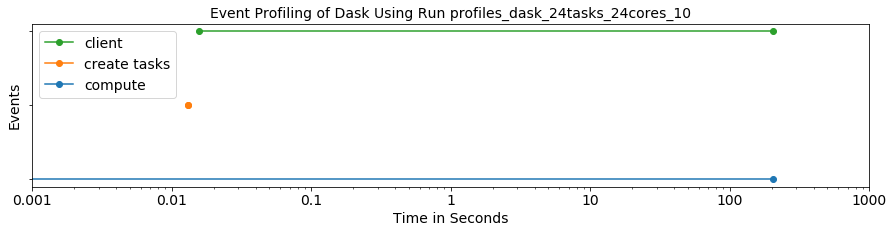

In [142]:
fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True)
fig.set_size_inches(15,3)

csv_file = os.path.join(folder, 'profiles_dask_24tasks_24cores_%s.csv' % 10)

raw_datadf = pd.read_csv(csv_file)
raw_datadf['times'] -= raw_datadf['times'][0]
raw_datadf['times_index'] = [1,1,2,2,3,3]

for key, group in raw_datadf.groupby('times_index'):
    axes.plot(group.times, group.times_index, marker='o')
    axes.set_xscale('log')
    axes.set_ylabel('Events',fontsize=14)
    axes.set_xlabel('Time in Seconds',fontsize=14)
    axes.set_xticks([10**i for i in range(-3,4)])
    axes.set_xticklabels([str(10**i) for i in range(-3,4)], fontsize=14)
    axes.set_yticks([i for i in range(1,4)])
    axes.set_yticklabels([])
    axes.set_title('Event Profiling of Dask Using Run %s' % ('profiles_dask_24tasks_24cores_%s' % 10), fontsize=14)    
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(reversed(handles), ['client', 'create tasks', 'compute'], loc='upper left', fontsize=14)
plt.show()